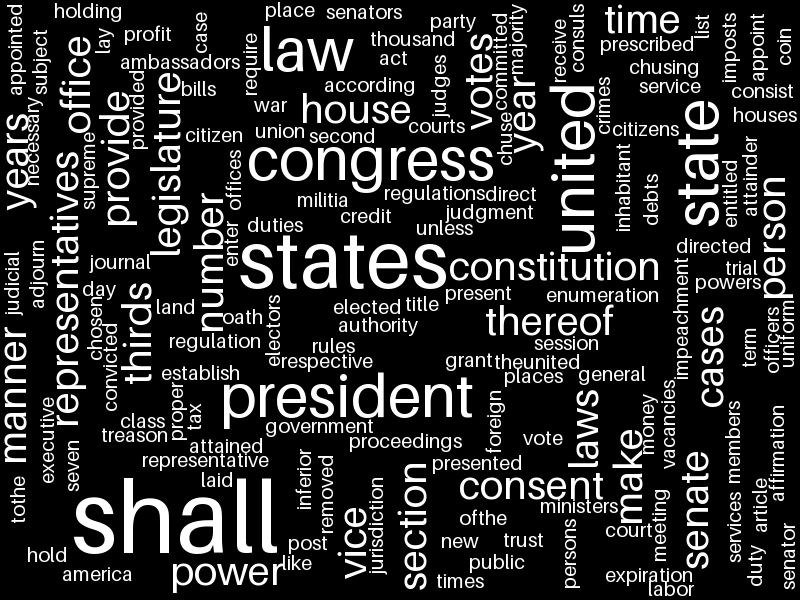

In [41]:
import random

import numpy as np
from PIL import ImageDraw, Image, ImageFont
from sklearn.feature_extraction.text import CountVectorizer


def query_integral_image(integral_image, size_x, size_y):
    x = integral_image.shape[0]
    y = integral_image.shape[1]
    hits = 0

    # count how many possible locations
    for i in range(x - size_x):
        for j in range(y - size_y):
            area = integral_image[i, j] + integral_image[i + size_x, j + size_y]
            area -= integral_image[i + size_x, j] + integral_image[i, j + size_y]
            if not area:
                hits += 1
    if not hits:
        # no room left
        return None
    # pick a location at random
    goal = np.random.randint(hits)
    hits = 0
    for i in range(x - size_x):
        for j in range(y - size_y):
            area = integral_image[i, j] + integral_image[i + size_x, j + size_y]
            area -= integral_image[i + size_x, j] + integral_image[i, j + size_y]
            if not area:
                hits += 1
                if hits == goal:
                    return i, j


with open("constitution.txt") as f:
    lines = f.readlines()
text = "".join(lines).replace("\n", "").replace("\t", "").replace("\r", "")

cv = CountVectorizer(min_df=0.0, stop_words="english", max_features=200)
counts = cv.fit_transform([text]).toarray().ravel()
words = np.array(cv.get_feature_names_out())
words = words[counts > 1]
counts = counts[counts > 1]

width = 800
height = 600

# sort words by counts
inds = np.argsort(counts)[::-1]
counts = counts[inds]
words = words[inds]
# create image
img = Image.new("L", (width, height))
draw = ImageDraw.Draw(img)
integral = np.zeros((height, width), dtype=np.uint)
img_array = np.asarray(img)

for word, count in zip(words, counts):
    # set font size
    font_size = int(np.log(count)) * 20
    runs = 0
    result = None
    while font_size > 0:
        font = ImageFont.load_default(font_size)
        # transpose font optionally
        orientation = random.choice([None, 2])
        font = ImageFont.TransposedFont(font, orientation=orientation)
        # get size of resulting text
        left, top, right, bottom = draw.textbbox((0, 0), word, font=font)
        width, height = right - left, bottom - top
        # find possible places using integral image:
        result = query_integral_image(integral, height, width)
        if result is not None:
            break
        # if we didn't find a place, make font smaller
        font_size -= 1
        runs += 1

    if result is None:
        continue
    x, y = result
    draw.text((result[1], result[0]), word, fill="white", font=font)
    # recompute integral image
    img_array = np.asarray(img)
    # recompute bottom right
    partial_integral = np.cumsum(np.cumsum(img_array[x:, y:], axis=0),
                                 axis=1)
    # paste into old image
    # if x or y is zero it is a bit annoying
    if x > 0:
        if y > 0:
            partial_integral += (integral[x - 1, y:]
                                 - integral[x - 1, y - 1])
        else:
            partial_integral += integral[x - 1, y:]
    if y > 0:
        partial_integral += integral[x:, y - 1][:, np.newaxis]

    integral[x:, y:] = partial_integral

display(img)